In [1]:
!git clone -b master  https://github.com/neuraloperator/neuraloperator.git

Cloning into 'neuraloperator'...
remote: Enumerating objects: 7774, done.
remote: Counting objects: 100% (1683/1683), done.
remote: Compressing objects: 100% (652/652), done.
remote: Total 7774 (delta 1070), reused 1575 (delta 1010), pack-reused 6091
Receiving objects: 100% (7774/7774), 74.26 MiB | 20.67 MiB/s, done.
Resolving deltas: 100% (5049/5049), done.


In [27]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [28]:
import scipy.io


mat_contents = scipy.io.loadmat('/content/drive/My Drive/burgers/burgers_data_R10.mat')

print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'a_smooth', 'a_smooth_x', 'a_x', 'u'])


In [ ]:
a = mat_contents['a']
a_smooth = mat_contents['a_smooth']
a_smooth_x = mat_contents['a_smooth_x']
a_x = mat_contents['a_x']
u = mat_contents['u']
print(a.shape)
print(a_smooth.shape)
print(a_smooth_x.shape)
print(a_x.shape)
print(u.shape)


(2048, 8192)
(2048, 8192)
(2048, 8191)
(2048, 8191)
(2048, 8192)


In [30]:
mat = scipy.io.loadmat('/content/drive/My Drive/burgers/burger_1d_solution.mat')

print(mat['pred'].shape)

(100, 1024)


In [ ]:
%cd /content/neuraloperator/

!python fourier_1d.py

In [2]:
!pip install scipy

In [13]:
!ls /content

burgers1.m  neuraloperator  sample_data


In [20]:
import scipy.io

with open('/content/neuraloperator/data_generation/burgers/GRF1.m', 'r') as file:
    content = file.read()
    print(content)

with open('/content/burgers1.m', 'r') as file:
    content = file.read()
    print(content)

with open('/content/neuraloperator/data_generation/burgers/gen_burgers1.m', 'r') as file:
    content = file.read()
    print(content)




%Radom function from N(m, C) on [0 1] where
%C = sigma^2(-Delta + tau^2 I)^(-gamma)
%with periodic, zero dirichlet, and zero neumann boundary.
%Dirichlet only supports m = 0.
%N is the # of Fourier modes, usually, grid size / 2.
function u = GRF1(N, m, gamma, tau, sigma, type)

if type == "dirichlet"
    m = 0;
end

if type == "periodic"
    my_const = 2*pi;
else
    my_const = pi;
end

my_eigs = sqrt(2)*(abs(sigma).*((my_const.*(1:N)').^2 + tau^2).^(-gamma/2));

if type == "dirichlet"
    alpha = zeros(N,1);
else
    xi_alpha = randn(N,1);
    alpha = my_eigs.*xi_alpha;
end

if type == "neumann"
    beta = zeros(N,1);
else
    xi_beta = randn(N,1);
    beta = my_eigs.*xi_beta;
end

a = alpha/2;
b = -beta/2;

c = [flipud(a) - flipud(b).*1i;m + 0*1i;a + b.*1i];

if type == "periodic"
    uu = chebfun(c, [0 1], 'trig', 'coeffs');
    u = chebfun(@(t) uu(t - 0.5), [0 1], 'trig');
else
    uu = chebfun(c, [-pi pi], 'trig', 'coeffs');
    u = chebfun(@(t) uu(pi*t), [0 1]);
end
function u = 

In [16]:
!pip install matlab

  Preparing metadata (setup.py) ... done
  Created wheel for matlab: filename=matlab-0.1-py3-none-any.whl size=1156 sha256=43523405626c6cd2c67b47ccf5ad14ce125e754d23c5f184aa70a543dcf3bc24
  Stored in directory: /root/.cache/pip/wheels/d1/d3/76/5314058ee22e7957a18eec0291788462f1df178bb08223bdd2
Successfully built matlab


In [18]:
import sys
print(sys.executable)


/usr/bin/python3


In [17]:
import matlab.engine

eng = matlab.engine.start_matlab()
eng.cd('path_to_directory_containing_burgers_m_file')  # Change to your directory
result = eng.burgers(nargout=1)  # Assuming 'burgers' is a function. Modify as needed.
print(result)
eng.quit()


ModuleNotFoundError: ignored

In [23]:
import torch

import math

from random_fields import GaussianRF

from timeit import default_timer

import scipy.io


#w0: initial vorticity
#f: forcing term
#visc: viscosity (1/Re)
#T: final time
#delta_t: internal time-step for solve (descrease if blow-up)
#record_steps: number of in-time snapshots to record
def navier_stokes_2d(w0, f, visc, T, delta_t=1e-4, record_steps=1):

    #Grid size - must be power of 2
    N = w0.size()[-1]

    #Maximum frequency
    k_max = math.floor(N/2.0)

    #Number of steps to final time
    steps = math.ceil(T/delta_t)

    #Initial vorticity to Fourier space
    w_h = torch.fft.rfft2(w0)

    #Forcing to Fourier space
    f_h = torch.fft.rfft2(f)

    #If same forcing for the whole batch
    if len(f_h.size()) < len(w_h.size()):
        f_h = torch.unsqueeze(f_h, 0)

    #Record solution every this number of steps
    record_time = math.floor(steps/record_steps)

    #Wavenumbers in y-direction
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w0.device), torch.arange(start=-k_max, end=0, step=1, device=w0.device)), 0).repeat(N,1)
    #Wavenumbers in x-direction
    k_x = k_y.transpose(0,1)

    #Truncate redundant modes
    k_x = k_x[..., :k_max + 1]
    k_y = k_y[..., :k_max + 1]

    #Negative Laplacian in Fourier space
    lap = 4*(math.pi**2)*(k_x**2 + k_y**2)
    lap[0,0] = 1.0
    #Dealiasing mask
    dealias = torch.unsqueeze(torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float(), 0)

    #Saving solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=w0.device)
    sol_t = torch.zeros(record_steps, device=w0.device)

    #Record counter
    c = 0
    #Physical time
    t = 0.0
    for j in range(steps):
        #Stream function in Fourier space: solve Poisson equation
        psi_h = w_h / lap

        #Velocity field in x-direction = psi_y
        q = 2. * math.pi * k_y * 1j * psi_h
        q = torch.fft.irfft2(q, s=(N, N))

        #Velocity field in y-direction = -psi_x
        v = -2. * math.pi * k_x * 1j * psi_h
        v = torch.fft.irfft2(v, s=(N, N))

        #Partial x of vorticity
        w_x = 2. * math.pi * k_x * 1j * w_h
        w_x = torch.fft.irfft2(w_x, s=(N, N))

        #Partial y of vorticity
        w_y = 2. * math.pi * k_y * 1j * w_h
        w_y = torch.fft.irfft2(w_y, s=(N, N))

        #Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = torch.fft.rfft2(q*w_x + v*w_y)

        #Dealias
        F_h = dealias* F_h

        #Crank-Nicolson update
        w_h = (-delta_t*F_h + delta_t*f_h + (1.0 - 0.5*delta_t*visc*lap)*w_h)/(1.0 + 0.5*delta_t*visc*lap)

        #Update real time (used only for recording)
        t += delta_t

        if (j+1) % record_time == 0:
            #Solution in physical space
            w = torch.fft.irfft2(w_h, s=(N, N))

            #Record solution and time
            sol[...,c] = w
            sol_t[c] = t

            c += 1


    return sol, sol_t


device = torch.device('cuda')

#Resolution
s = 256

#Number of solutions to generate
N = 20

#Set up 2d GRF with covariance parameters
GRF = GaussianRF(2, s, alpha=2.5, tau=7, device=device)

#Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
t = torch.linspace(0, 1, s+1, device=device)
t = t[0:-1]

X,Y = torch.meshgrid(t, t, indexing='ij')
f = 0.1*(torch.sin(2*math.pi*(X + Y)) + torch.cos(2*math.pi*(X + Y)))

#Number of snapshots from solution
record_steps = 200

#Inputs
a = torch.zeros(N, s, s)
#Solutions
u = torch.zeros(N, s, s, record_steps)

#Solve equations in batches (order of magnitude speed-up)

#Batch size
bsize = 20

c = 0
t0 =default_timer()
for j in range(N//bsize):

    #Sample random feilds
    w0 = GRF.sample(bsize)

    #Solve NS
    sol, sol_t = navier_stokes_2d(w0, f, 1e-3, 50.0, 1e-4, record_steps)

    a[c:(c+bsize),...] = w0
    u[c:(c+bsize),...] = sol

    c += bsize
    t1 = default_timer()
    print(j, c, t1-t0)

scipy.io.savemat('ns_data.mat', mdict={'a': a.cpu().numpy(), 'u': u.cpu().numpy(), 't': sol_t.cpu().numpy()})


0 20 300.05255124700034


In [57]:
"""
#1d generator

import torch
import math

class GaussianRF:
    def __init__(self, size, alpha, tau, sigma, boundary="periodic", device=None):
        self.size = size
        self.device = device

        k_max = size // 2
        k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                       torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

        self.sqrt_eig = size * math.sqrt(2.0) * sigma * ((4 * (math.pi ** 2) * (k ** 2) + tau ** 2) ** (-alpha / 2.0))
        self.sqrt_eig[0] = 0.0

    def sample(self):
        coeff = torch.randn(self.size, dtype=torch.cfloat, device=self.device)
        coeff = self.sqrt_eig * coeff
        return torch.fft.ifft(coeff).real

def burgers_solver(u0, t_span, s, visc, device):
    dt = (t_span[1] - t_span[0]) / s
    u = u0.clone().to(device)  # Ensure u is on the same device as u0
    k = torch.fft.fftfreq(s, d=dt) * 2 * math.pi
    k = k.to(device)  # Move k to the same device

    for _ in range(s):
        u_hat = torch.fft.fft(u).to(device)  # Ensure u_hat is on the same device
        dudx = torch.fft.ifft(1j * k * u_hat).real.to(device)  # Move the result of ifft to the device
        d2udx2 = torch.fft.ifft(-k ** 2 * u_hat).real.to(device)  # Move the result of ifft to the device
        u += dt * (-0.5 * dudx * u + visc * d2udx2)  # Perform the update

    return u


# Parameters
N =  200 # Number of realizations
gamma = 2.5
tau = 7
sigma = 7 ** 2
visc = 3 / 1000
s = 2048
steps = 1

# Initialize arrays using PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_data = torch.zeros((N, s), device=device)
output_data = torch.zeros((N, s), device=device)

# Time and space discretization
t_span = (0, 1)
x = torch.linspace(0, 1, s, device=device)

# GRF instance
grf = GaussianRF(s, gamma, tau, sigma, device=device)

# Generate data
for j in range(N):
    u0 = grf.sample()
    u = burgers_solver(u0, t_span, s, visc, device)
    input_data[j, :] = u0
    output_data[j, :] = u

    #print(f"Realization {j+1}/{N}")

# Convert data to NumPy arrays if needed
input_data_np = input_data.cpu().numpy()
output_data_np = output_data.cpu().numpy()

# Print or save the data
print(input_data_np)
print("output", output_data_np)

[[ 0.1144795   0.11487673  0.11526961 ...  0.11331223  0.11368349
   0.11407377]
 [-0.46683526 -0.46827042 -0.46969423 ... -0.46249777 -0.46394843
  -0.46539396]
 [-0.07225448 -0.07471505 -0.0771648  ... -0.06477416 -0.06728841
  -0.06978257]
 ...
 [-0.10769732 -0.10597388 -0.10425404 ... -0.11293159 -0.1111661
  -0.10942893]
 [-0.08850709 -0.08756597 -0.08661892 ... -0.09129161 -0.09037948
  -0.08944818]
 [-0.24967104 -0.2476138  -0.24556372 ... -0.25594655 -0.2538319
  -0.25174144]]
output [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [25]:
mat = scipy.io.loadmat('/content/ns_data.mat')

print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'a', 'u', 't'])


In [50]:
"""
import torch
import math
from random_fields import GaussianRF
import scipy.io

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
N = 3
gamma = 2.5
tau = 7
sigma = 7 ** 2
visc = 1 / 1000
s = 1024
steps = 200

# Initialize GaussianRF
grf = GaussianRF(1, s, gamma, tau, sigma, boundary="periodic", device=device)

t_span = (0, 1)

def burgers_solver(u0, t_span, s, visc, device=device):
    dt = (t_span[1] - t_span[0]) / s
    u = u0.clone().to(device)
    for _ in range(s):
        u_hat = torch.fft.fft(u).to(device)
        k = torch.fft.fftfreq(s, d=dt) * 2 * math.pi
        k = k.to(device)
        dudx = torch.fft.ifft(1j * k * u_hat).real.to(device)
        d2udx2 = torch.fft.ifft(-k ** 2 * u_hat).real.to(device)
        u += dt * (-0.5 * dudx * u + visc * d2udx2)
    return u

# Initialize data storage
input_data = torch.zeros(N, s, device=device)
output_data = torch.zeros(N, s, device=device)

for j in range(N):
    u0_sampled = grf.sample(N).to(device)  # Sample from GaussianRF
    u = burgers_solver(u0_sampled, t_span, s, visc)
    input_data[j, :] = u0_sampled
    output_data[j, :] = u
    print(f"Realization {j+1}/{N}")

# Convert data to NumPy arrays for saving
input_data_np = input_data.cpu().numpy()
output_data_np = output_data.cpu().numpy()

print(input_data_np.shape)
print(output_data_np.shape)
# Save the data
#scipy.io.savemat('data.mat', {'input_data': input_data_np, 'output_data': output_data_np})



RuntimeError: ignored

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import torch.nn.functional as F
from timeit import default_timer
from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(2, self.width) # input channel_dim is 2: (u0(x), x)
        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width*2)  # output channel_dim is 1: u1(x)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

################################################################
import torch
import math
import torch.nn.functional as F
from torch.utils.data import DataLoader
from timeit import default_timer

# Gaussian Random Field Class
class GaussianRF:
    def __init__(self, size, alpha, tau, sigma, boundary="periodic", device=None):
        self.size = size
        self.device = device

        k_max = size // 2
        k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                       torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

        self.sqrt_eig = size * math.sqrt(2.0) * sigma * ((4 * (math.pi ** 2) * (k ** 2) + tau ** 2) ** (-alpha / 2.0))
        self.sqrt_eig[0] = 0.0

    def sample(self):
        coeff = torch.randn(self.size, dtype=torch.cfloat, device=self.device)
        coeff = self.sqrt_eig * coeff
        return torch.fft.ifft(coeff).real

# Burgers' Equation Solver using Crank-Nicolson Method
def burgers_solver_cn(u0, t_span, s, visc, device):
    dt = (t_span[1] - t_span[0]) / s
    u = u0.clone()
    k = torch.fft.fftfreq(s, d=dt).to(device) * 2 * math.pi

    laplacian = -k ** 2
    for _ in range(s):
        u_hat = torch.fft.fft(u)
        dudx = torch.fft.ifft(1j * k * u_hat).real
        nonlinear_term = -0.5 * dudx * u

        # Crank-Nicolson update
        u_hat_new = (torch.fft.fft(u + dt * nonlinear_term)) / (1 - 0.5 * dt * visc * laplacian)
        u = torch.fft.ifft(u_hat_new).real

    return u


# Function to generate Burgers' equation data
def generate_burgers_data(N, s, visc, gamma, tau, sigma, device):
    t_span = (0, 1)
    input_data = torch.zeros((N, s), device=device)
    output_data = torch.zeros((N, s), device=device)
    grf = GaussianRF(s, gamma, tau, sigma, device=device)

    for j in range(N):
        u0 = grf.sample()
        u = burgers_solver_cn(u0, t_span, s, visc, device)
        input_data[j, :] = u0
        output_data[j, :] = u

    return input_data, output_data


# Function to train the model
def train_model(train_loader, epochs, batch_size, modes, width, learning_rate):
    device = torch.device("cuda")
    model = FNO1d(modes, width).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    myloss = LpLoss(size_average=False)

    for ep in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            loss.backward()
            optimizer.step()
            scheduler.step()

    return model


# Function to evaluate the model
def evaluate_model(model, test_loader):
    device = torch.device("cuda")
    model.eval()
    myloss = LpLoss(size_average=False)
    test_loss = 0.0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            test_loss += myloss(out.view(-1), y.view(-1)).item()

    test_loss /= len(test_loader)
    return test_loss


# Main Experiment
def run_experiment(visc, gamma, tau, sigma, N=128, s=2048, ntrain=100, ntest=10, epochs=500, batch_size=20, learning_rate=0.001, modes=16, width=64):
    device = torch.device("cuda")

    # Generate data
    input_data, output_data = generate_burgers_data(N, s, visc, gamma, tau, sigma, device)

    # Prepare data for training and testing
    sub = 2**1
    h = 2**13 // sub
    s = h
    x_data = input_data[:, ::sub]
    y_data = output_data[:, ::sub]
    x_train = x_data[:ntrain, :].reshape(ntrain, s, 1)
    y_train = y_data[:ntrain, :]
    x_test = x_data[-ntest:, :].reshape(ntest, s, 1)
    y_test = y_data[-ntest:, :]

    # Data loaders
    train_loader = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

    # Train model
    model = train_model(train_loader, epochs, batch_size, modes, width, learning_rate)

    # Evaluate model
    test_loss = evaluate_model(model, test_loader)
    print(f"Test Loss: {test_loss}")

    # Save model if needed
    # torch.save(model, 'model/ns_fourier_burgers')

# Run the experiment with specific parameters
run_experiment(visc=3/1000, gamma=2.5, tau=7, sigma=49, N=512, s=8192, ntrain=400, ntest=40, epochs=200, batch_size=20, learning_rate=0.001, modes=16, width=64)

DATA GENERATION

In [58]:
class GaussianRF:
    def __init__(self, size, alpha, tau, sigma, boundary="periodic", device=None):
        self.size = size
        self.device = device

        k_max = size // 2
        k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                       torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

        self.sqrt_eig = size * math.sqrt(2.0) * sigma * ((4 * (math.pi ** 2) * (k ** 2) + tau ** 2) ** (-alpha / 2.0))
        self.sqrt_eig[0] = 0.0

    def sample(self):
        coeff = torch.randn(self.size, dtype=torch.cfloat, device=self.device)
        coeff = self.sqrt_eig * coeff
        return torch.fft.ifft(coeff).real

# Burgers' Equation Solver using Crank-Nicolson Method
def burgers_solver_cn(u0, t_span, s, visc, device):
    dt = (t_span[1] - t_span[0]) / s
    u = u0.clone()
    k = torch.fft.fftfreq(s, d=dt).to(device) * 2 * math.pi

    laplacian = -k ** 2
    for _ in range(s):
        u_hat = torch.fft.fft(u)
        dudx = torch.fft.ifft(1j * k * u_hat).real
        nonlinear_term = -0.5 * dudx * u

        # Crank-Nicolson update
        u_hat_new = (torch.fft.fft(u + dt * nonlinear_term)) / (1 - 0.5 * dt * visc * laplacian)
        u = torch.fft.ifft(u_hat_new).real

    return u


# Function to generate Burgers' equation data
def generate_burgers_data(N, s, visc, gamma, tau, sigma, device):
    t_span = (0, 1)
    input_data = torch.zeros((N, s), device=device)
    output_data = torch.zeros((N, s), device=device)
    grf = GaussianRF(s, gamma, tau, sigma, device=device)

    for j in range(N):
        u0 = grf.sample()
        u = burgers_solver_cn(u0, t_span, s, visc, device)
        input_data[j, :] = u0
        output_data[j, :] = u

    return input_data, output_data



In [69]:
N =  200 # Number of realizations
gamma = 2.5
tau = 7
sigma = 7 ** 2
visc = [3, 3/10, 3/100, 3 / 1000, 3/10000, 3/100000]
s = 2048
steps = 1

device = torch.device("cuda")
all = {}
# Generate data
for v in visc:
  print(v)
  _, output_data = generate_burgers_data(N, s, v, gamma, tau, sigma, device)
  all[v] = output_data

3
0.3
0.03
0.003
0.0003
3e-05


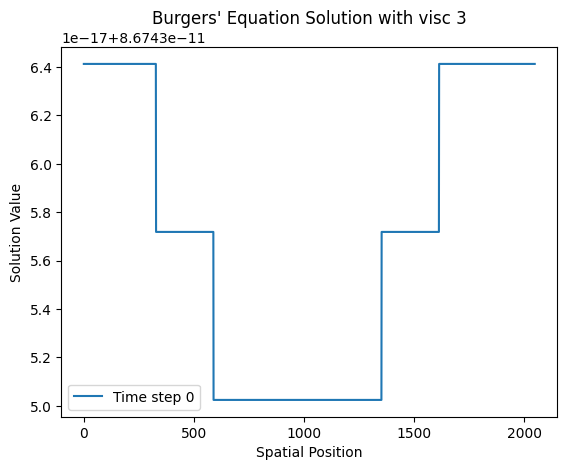

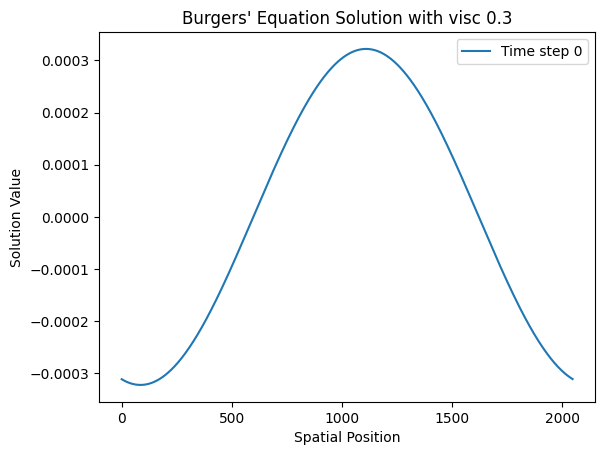

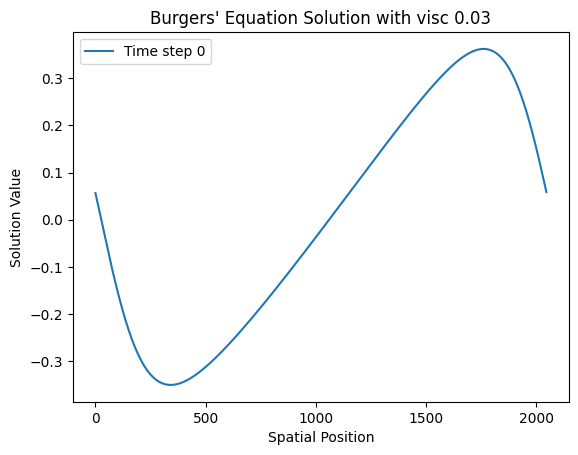

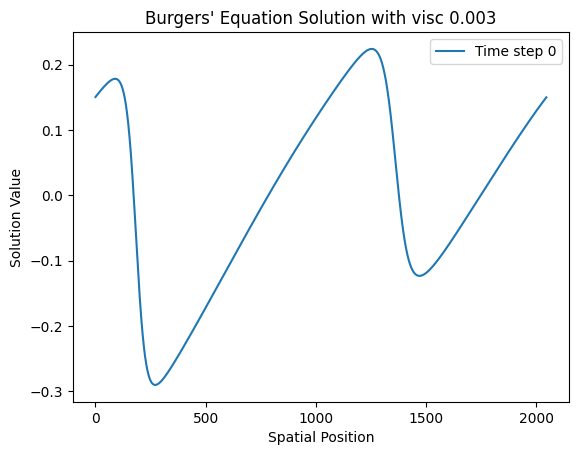

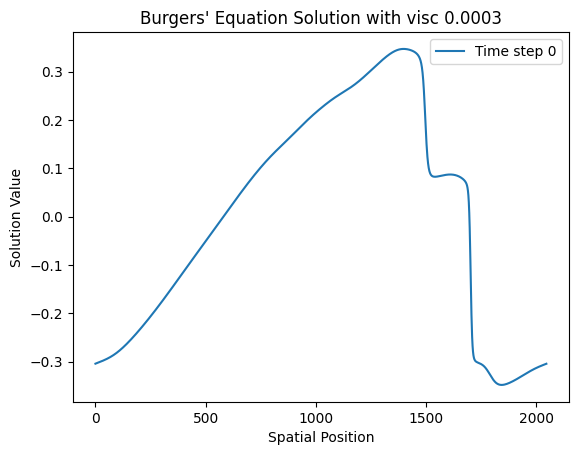

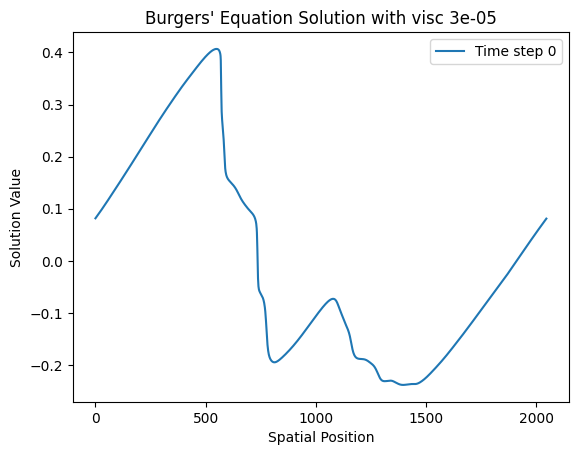

In [71]:
import matplotlib.pyplot as plt
import numpy as np
for v in visc:
    u = all[v]
    u_numpy = u.cpu().numpy()
    # Create a figure and an axis



    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plotting the solution at a specific time step
    time_step_index = 0  # for example, the first time step
    ax.plot(u_numpy[time_step_index, :], label=f"Time step {time_step_index}")

    # Adding labels and title
    ax.set_xlabel("Spatial Position")
    ax.set_ylabel("Solution Value")
    ax.set_title(f"Burgers' Equation Solution with visc {v}")

    ax.legend()
    plt.show()


In [86]:
#derivative comparison

def calculate_derivative(data, dx):
    return np.diff(data) / dx

fig, ax = plt.subplots(figsize=(10, 6))


dx = 0.1  # Adjust as you like

n = 1000  # Plot every nth point
for label, data in all.items():
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()

    derivative = calculate_derivative(data[::n], dx)
    ax.plot(derivative, label=f"Derivative {label}")


ax.set_xlabel("Spatial Position")
ax.set_ylabel("First Derivative")
ax.set_title("First Derivatives of Different Outputs")
ax.legend()

fig.savefig("plot.png", dpi=300)  # Adjust filename and dpi as needed



ValueError: ignored

<Figure size 1000x600 with 1 Axes>

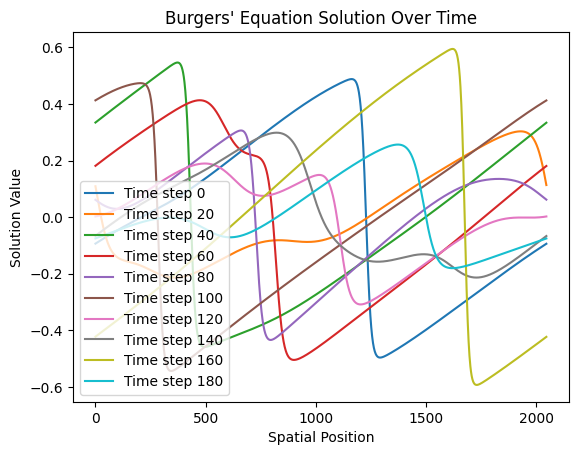

In [67]:
fig, ax = plt.subplots()
number_of_time_steps = u_numpy.shape[0]

# Plotting the solution at a few specific time steps
step = 20
for time_step_index in range(0, number_of_time_steps, step):
    ax.plot(u_numpy[time_step_index, :], label=f"Time step {time_step_index}")

ax.set_xlabel("Spatial Position")
ax.set_ylabel("Solution Value")
ax.set_title("Burgers' Equation Solution Over Time")
ax.legend()
plt.show()


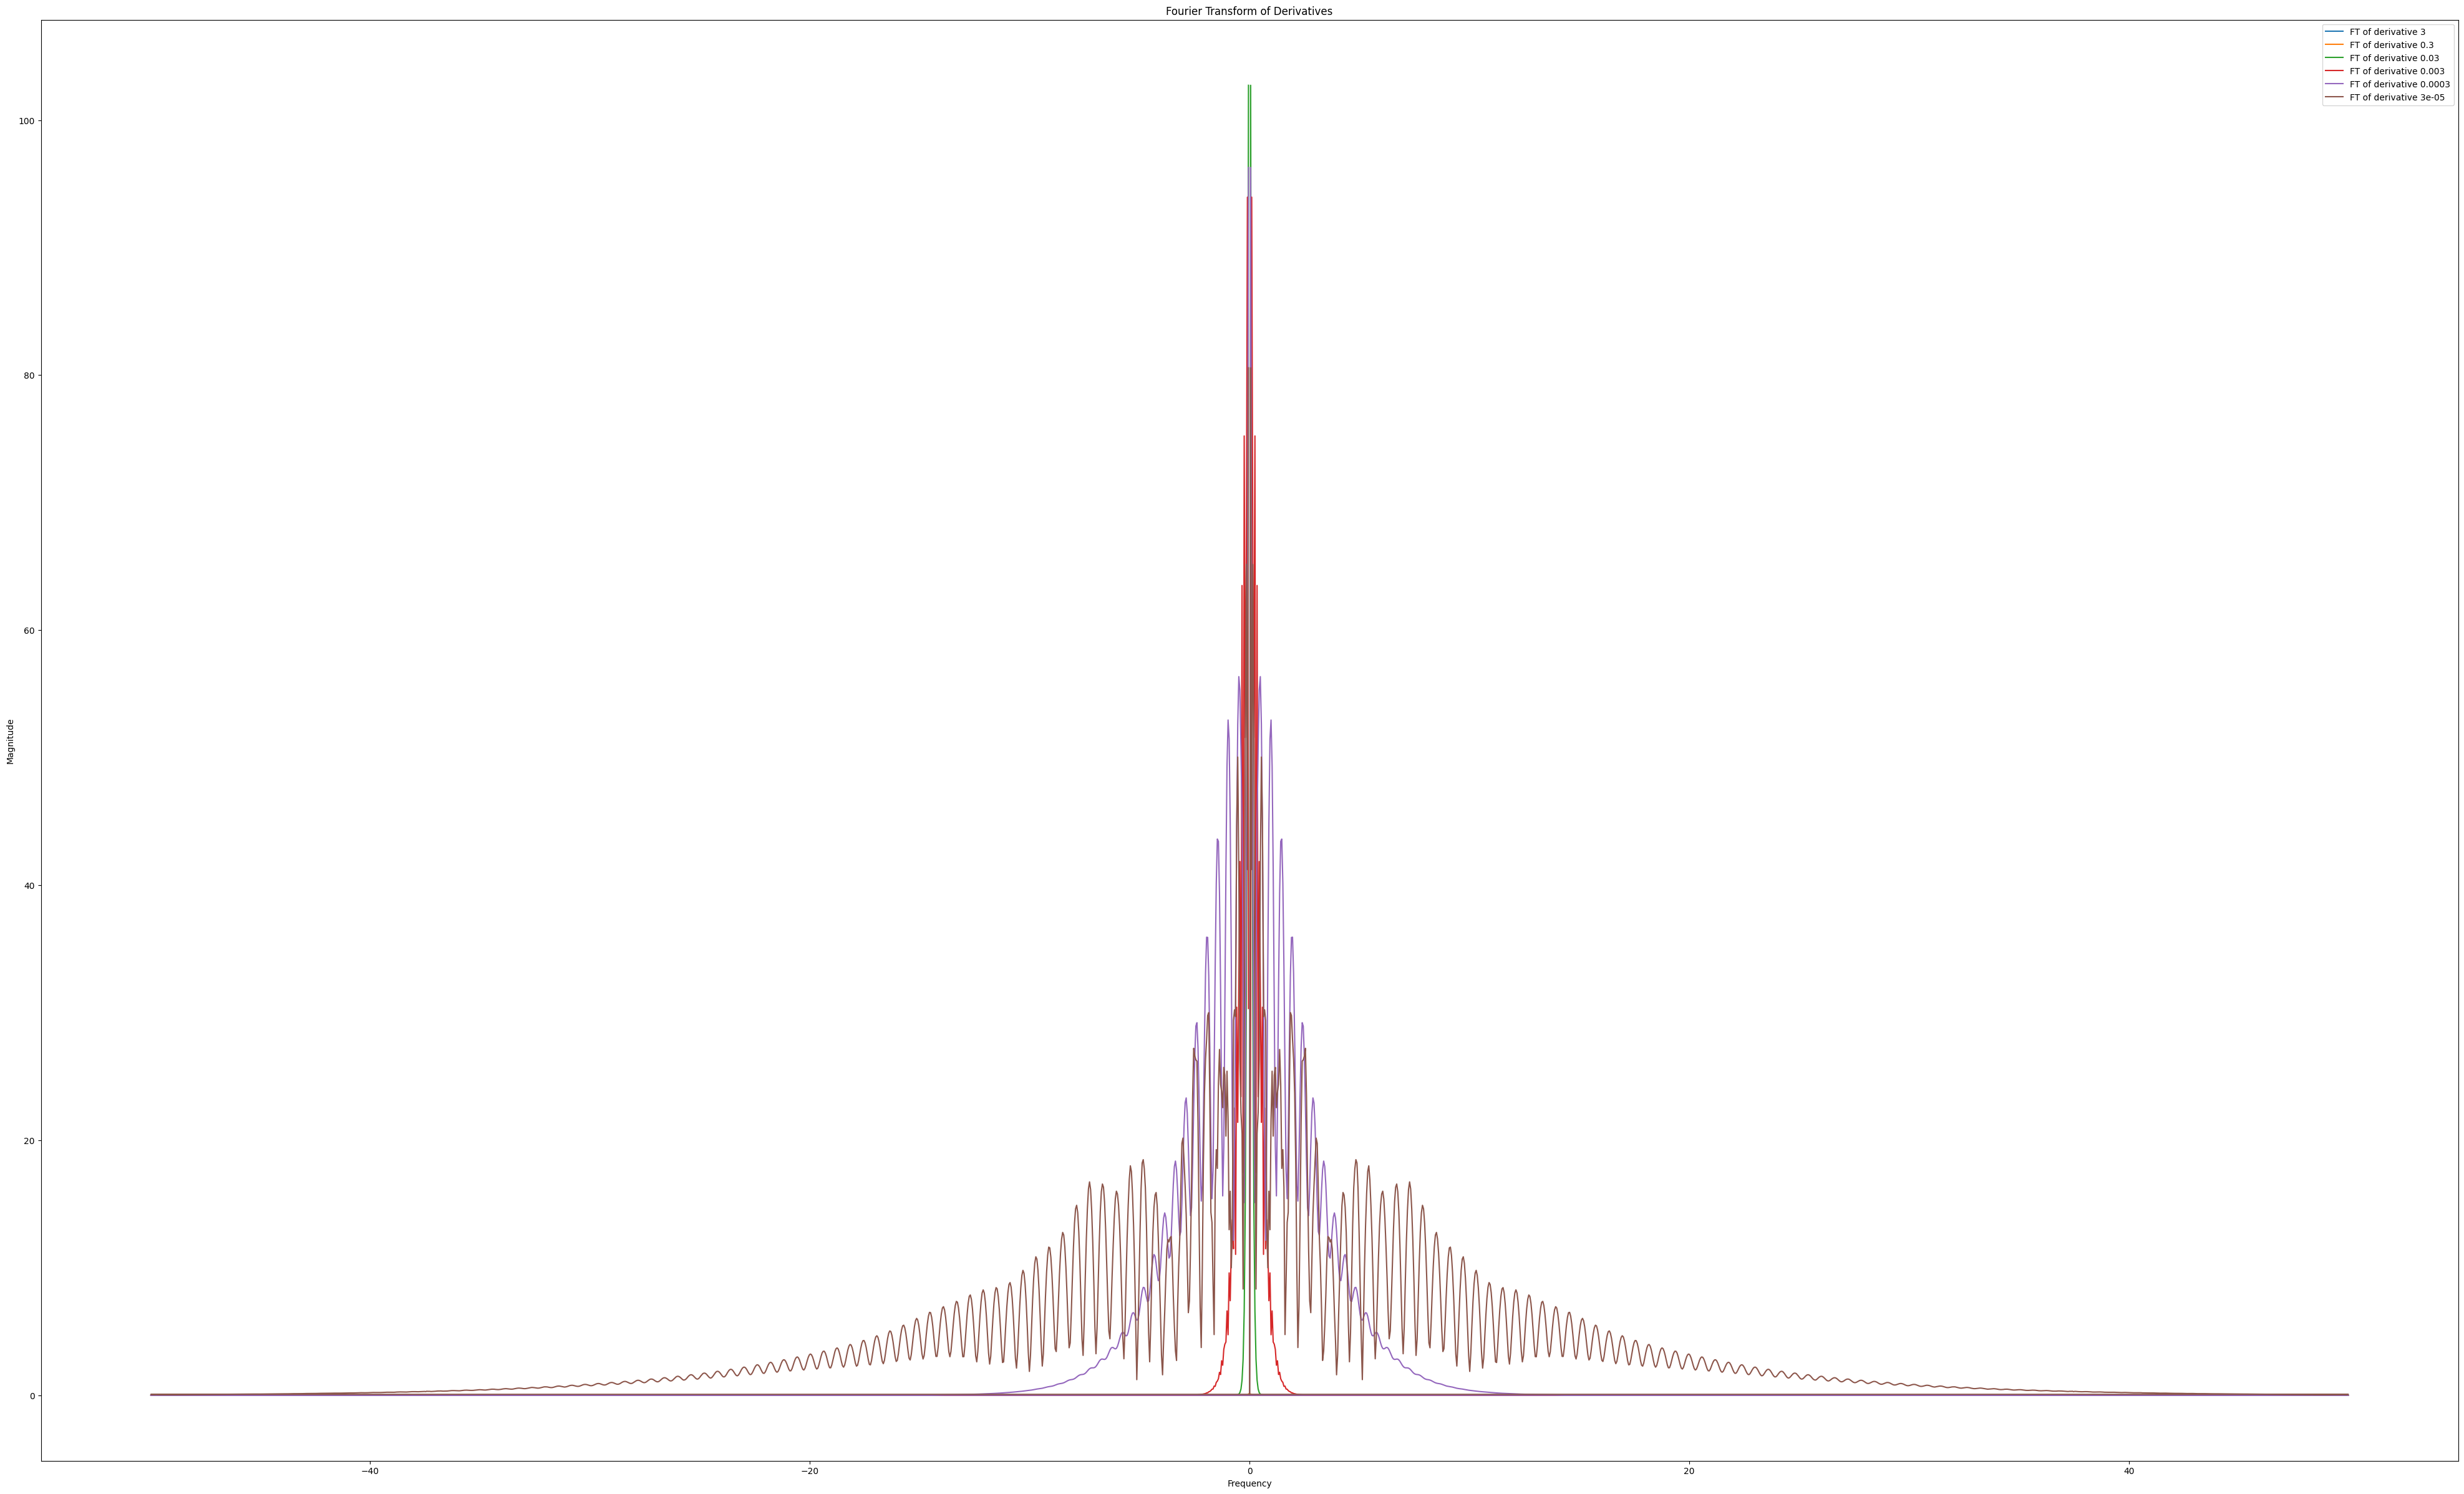

In [84]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 30))

# Assuming 'all' is your dictionary
dx = 0.01  # Spatial step size

for label, data in all.items():
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()

    # Select a specific sample or average over samples
    # For example, using the first sample here
    sample_data = data[0, :]

    # Compute the Fourier Transform of the derivative
    derivative = np.diff(sample_data) / dx
    ft = np.fft.fft(derivative)
    frequencies = np.fft.fftfreq(derivative.size, d=dx)

    # Compute the magnitude of the Fourier Transform
    magnitude = np.abs(ft)

    # Plot
    ax.plot(frequencies, magnitude, label=f"FT of derivative {label}")

ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')
ax.set_title('Fourier Transform of Derivatives')
ax.legend()
plt.show()


